In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [65]:
n_steps = int(1e5)
v = 0.01
nProbes = 1000
file = open('0908/transition_1000_1000_42_237.pos', 'r')

In [66]:
# read tetra info and initial probe info
line1 = file.readline()
line2 = file.readline()

tetraId = [int(i) for i in line1.split(' ')[:-1]]
tetraId.append(-1)
numProbes = [int(i) for i in line2.split(' ')[:-1]]
numProbes.append(nProbes - sum(numProbes))

In [67]:
# read jumps info
lines = file.readlines()
t = []
s1 = []
s2 = []

for line in lines:
    data = line.strip().split()
    tTmp = int(data[0])

    for i in range(len(data[1:])):
        s1Tmp, s2Tmp = data[1:][i].split(',')
        t.append(tTmp)
        s1.append(int(s1Tmp))
        s2.append(int(s2Tmp))

jumps = pd.DataFrame({'t': t, 's1': s1, 's2': s2})
jumps = jumps.sort_values(by=['t', 's1', 's2'])

In [68]:
# create population dataset
z = [(x, y) for x, y in zip(tetraId, numProbes)]
z.sort()
tetraId, numProbes = zip(*z)
tetraId = list(tetraId)
numProbes = np.array(numProbes)

tetraId_to_idx = {tid: idx for idx, tid in enumerate(tetraId)}

jumps_sorted = jumps.sort_values(by=['t', 's1', 's2'])
t_arr = jumps_sorted['t'].to_numpy()
s1_arr = jumps_sorted['s1'].to_numpy()
s2_arr = jumps_sorted['s2'].to_numpy()

s1_idx = np.array([tetraId_to_idx[s] for s in s1_arr])
s2_idx = np.array([tetraId_to_idx[s] for s in s2_arr])

n_tetra = len(tetraId)
pop_matrix = np.zeros((n_steps + 1, n_tetra), dtype=int)
pop_matrix[0] = numProbes

# For each time step, apply all jumps
for t in range(n_steps):
    pop_matrix[t + 1] = pop_matrix[t]
    mask = (t_arr == t)
    # Count net changes for each tetraId at this time step
    if np.any(mask):
        # For all jumps at this t, subtract 1 from s1, add 1 to s2
        np.subtract.at(pop_matrix[t + 1], s1_idx[mask], 1)
        np.add.at(pop_matrix[t + 1], s2_idx[mask], 1)

population = pd.DataFrame(pop_matrix, columns=tetraId)

(0.0, 500.0)

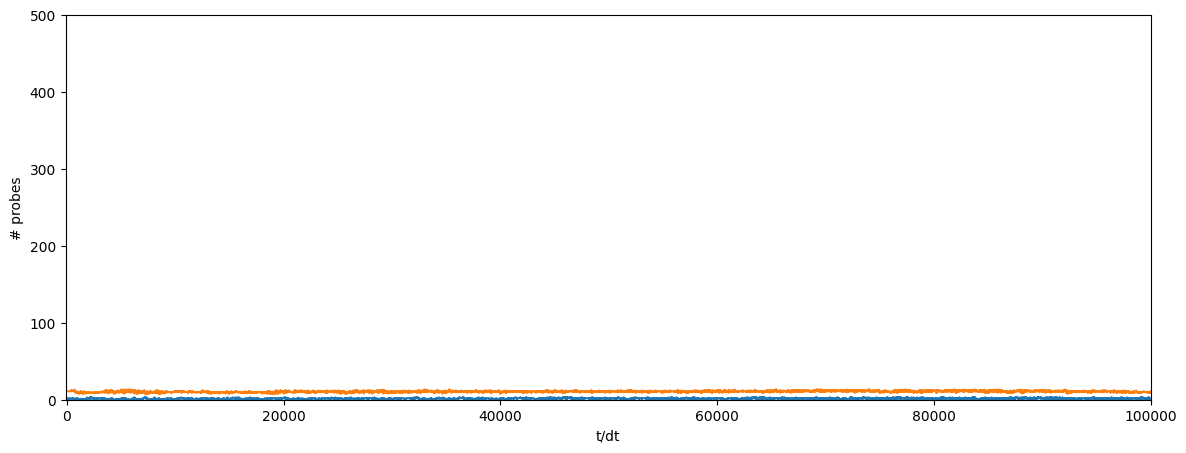

In [69]:
plt.figure(figsize=(14, 5))

plt.plot(population.iloc[:, 1])
plt.plot(population[population.iloc[-1].idxmax()])

plt.xlabel('t/dt')
plt.ylabel('# probes')
plt.xlim(-1e2, n_steps)
plt.ylim(0, 500)

In [70]:
N = population.iloc[int(1e4):].mean()
jumps = jumps[jumps['t'] > int(1e4)]

s1_indices = np.array([tetraId_to_idx[s] for s in jumps['s1']])
s2_indices = np.array([tetraId_to_idx[s] for s in jumps['s2']])
Jij = np.zeros((len(tetraId), len(tetraId)))
np.add.at(Jij, (s1_indices, s2_indices), 1)

Tj = jumps['t'].max() - jumps['t'].min() + 1
N = N * Tj

In [71]:
with np.errstate(divide='ignore', invalid='ignore'):
    Tij = np.where(N.values[:, None] == 0, 0, Jij / N.values[:, None])
np.fill_diagonal(Tij, 0)
Tij[np.arange(len(tetraId)), np.arange(len(tetraId))] = -Tij.sum(axis=1)

In [72]:
channel = pd.read_csv('0908/1000_42_area.txt')
channel

,i,j,area
0,525,4302,1.346497
1,525,4379,1.201940
2,525,1735,0.912809
3,587,1636,1.262791
4,587,4367,0.116779
...,...,...,...
1576,173376,173378,0.227806
1577,173377,173383,0.243089
1578,173377,173378,0.514443
1579,177284,177286,0.443462


In [73]:
tetraInfo = pd.read_csv('0908/1000_42_tetra.txt')
tetraInfo


,id,obstacles_id,x,y,z,is_prime,image_id,is_percolation,percolation_id,volume,vol_fraction,vol_fraction_cum,num_probes
0,525,"[164, 201, 909, 914]",4.740495,4.149215,10.797355,True,525,True,0,0.581364,0.001814,0.001814,19
1,587,"[164, 321, 909, 969]",5.903142,5.283448,9.281490,True,587,True,1,0.572754,0.001787,0.003601,18
2,1636,"[164, 689, 909, 969]",5.473705,4.721441,9.071585,True,1636,True,2,0.057909,0.000181,0.003781,2
3,1723,"[5, 293, 518, 973]",5.005247,5.344308,13.847752,True,1723,True,3,0.007276,0.000023,0.003804,1
4,1724,"[94, 164, 231, 741]",6.203440,2.263440,11.679625,True,1724,True,4,0.559493,0.001746,0.005550,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,177286,"[507, 13928, 21584, 22765]",21.261106,5.402623,0.284793,True,177286,True,1220,0.126999,0.000396,0.999025,4
1221,177288,"[50, 507, 22718, 22765]",21.350183,5.691457,2.264111,True,177288,True,1221,0.208361,0.000650,0.999675,7
1222,177300,"[507, 805, 22765, 22806]",21.146206,7.609564,1.844253,True,177300,True,1222,0.006643,0.000021,0.999696,1
1223,177484,"[55, 302, 370, 950]",17.428814,6.346195,4.724919,True,177484,True,1223,0.039305,0.000123,0.999819,2


In [74]:
channel = channel.merge(tetraInfo[['id','volume']].rename(columns={'volume': 'v_i'}), left_on='i', right_on='id').drop(columns=['id'])
channel = channel.merge(tetraInfo[['id','volume']].rename(columns={'volume': 'v_j'}), left_on='j', right_on='id').drop(columns=['id'])
channel

,i,j,area,v_i,v_j
0,525,4302,1.346497,0.581364,1.030397
1,4297,4302,0.264222,0.920471,1.030397
2,4301,4302,0.487642,0.041841,1.030397
3,525,4379,1.201940,0.581364,0.017823
4,525,1735,0.912809,0.581364,0.085513
...,...,...,...,...,...
1576,173367,173368,0.140469,0.109601,0.020088
1577,173372,173376,0.061205,0.007873,0.017132
1578,173376,173378,0.227806,0.017132,0.115346
1579,173377,173378,0.514443,0.401882,0.115346


In [75]:
channel['Tij'] = float(0)
channel['Tji'] = float(0)

# Map tetraId to index for fast lookup
tetraId_to_idx = {tid: idx for idx, tid in enumerate(tetraId)}
i_idx = channel['i'].map(tetraId_to_idx)
j_idx = channel['j'].map(tetraId_to_idx)
channel['Tij'] = Tij[i_idx, j_idx]
channel['Tji'] = Tij[j_idx, i_idx]

channel

,i,j,area,v_i,v_j,Tij,Tji
0,525,4302,1.346497,0.581364,1.030397,0.003405,0.002745
1,4297,4302,0.264222,0.920471,1.030397,0.000642,0.000484
2,4301,4302,0.487642,0.041841,1.030397,0.006000,0.001188
3,525,4379,1.201940,0.581364,0.017823,0.000452,0.012708
4,525,1735,0.912809,0.581364,0.085513,0.006647,0.021839
...,...,...,...,...,...,...,...
1576,173367,173368,0.140469,0.109601,0.020088,0.001278,0.004801
1577,173372,173376,0.061205,0.007873,0.017132,0.024090,0.044578
1578,173376,173378,0.227806,0.017132,0.115346,0.001725,0.000471
1579,173377,173378,0.514443,0.401882,0.115346,0.000297,0.000683


In [76]:
transitionRate1 = channel[['area', 'v_i', 'Tij', 'v_j']].rename(columns={'v_i': 'v', 'Tij': 'T', 'v_j': 'v_neighbor'})
transitionRate2 = channel[['area', 'v_j', 'Tji', 'v_i']].rename(columns={'v_j': 'v', 'Tji': 'T', 'v_i': 'v_neighbor'})
transitionRate = pd.concat([transitionRate1, transitionRate2])
transitionRate

,area,v,T,v_neighbor
0,1.346497,0.581364,0.003405,1.030397
1,0.264222,0.920471,0.000642,1.030397
2,0.487642,0.041841,0.006000,1.030397
3,1.201940,0.581364,0.000452,0.017823
4,0.912809,0.581364,0.006647,0.085513
...,...,...,...,...
1576,0.140469,0.020088,0.004801,0.109601
1577,0.061205,0.017132,0.044578,0.007873
1578,0.227806,0.115346,0.000471,0.017132
1579,0.514443,0.115346,0.000683,0.401882


In [77]:
transitionRate['logV'] = np.log(transitionRate['v'])
transitionRate['logV_neighbor'] = np.log(transitionRate['v_neighbor'])
transitionRate['logT'] = np.log(transitionRate['T'])
transitionRate['logA'] = np.log(transitionRate['area'])
transitionRate.reset_index(drop=True, inplace=True)

/Users/yitongzheng/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/yitongzheng/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/yitongzheng/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


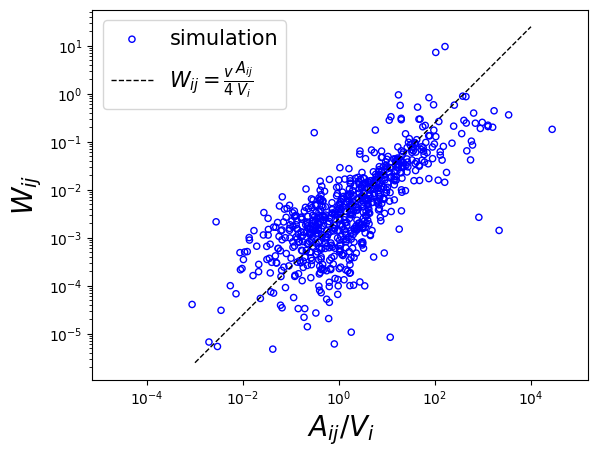

In [78]:
transitionRate['AV'] = transitionRate['area']**(1) / transitionRate['v']**(1)

a = transitionRate['area'].to_numpy()
x = transitionRate['AV'].to_numpy()
y = transitionRate['T'].to_numpy()

th = 0.1
x = x[np.where(a < th)]
y = y[np.where(a < th)]


plt.scatter(x, y, s=20, marker='o', facecolors='none', edgecolors='b')
plt.plot([1e-3, 1e4], np.array([1e-3, 1e4])*v/4, 'k--', linewidth=1.0)
plt.xlabel(r'$A_{ij}/V_i$', fontsize=20)
plt.ylabel(r'$W_{ij}$', fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.axis('equal')
plt.legend(['simulation', r'$W_{ij}=\frac{v}{4}\frac{A_{ij}}{V_i}$'], fontsize=15)
plt.show()

In [79]:
transitionRate['error'] = transitionRate['T'] / transitionRate['AV']
transitionRate

,area,v,T,v_neighbor,logV,logV_neighbor,logT,logA,AV,error
0,1.346497,0.581364,0.003405,1.030397,-0.542378,0.029944,-5.682596,0.297506,2.316098,0.001470
1,0.264222,0.920471,0.000642,1.030397,-0.082870,0.029944,-7.351073,-1.330966,0.287051,0.002236
2,0.487642,0.041841,0.006000,1.030397,-3.173871,0.029944,-5.116065,-0.718174,11.654546,0.000515
3,1.201940,0.581364,0.000452,0.017823,-0.542378,-4.027270,-7.701259,0.183937,2.067447,0.000219
4,0.912809,0.581364,0.006647,0.085513,-0.542378,-2.459088,-5.013565,-0.091229,1.570115,0.004234
...,...,...,...,...,...,...,...,...,...,...
3157,0.140469,0.020088,0.004801,0.109601,-3.907618,-2.210908,-5.339029,-1.962766,6.992598,0.000687
3158,0.061205,0.017132,0.044578,0.007873,-4.066792,-4.844264,-3.110523,-2.793523,3.572510,0.012478
3159,0.227806,0.115346,0.000471,0.017132,-2.159819,-4.066792,-7.660619,-1.479262,1.974977,0.000238
3160,0.514443,0.115346,0.000683,0.401882,-2.159819,-0.911596,-7.288520,-0.664671,4.459998,0.000153


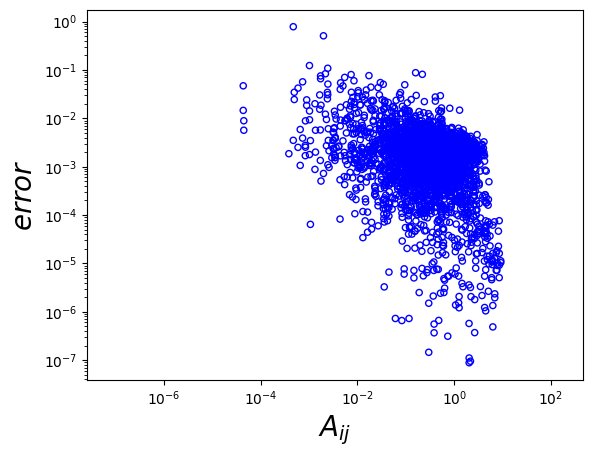

In [80]:
x = transitionRate['area'].to_numpy()
y = transitionRate['error'].to_numpy()

plt.scatter(x, y, s=20, marker='o', facecolors='none', edgecolors='b')
plt.xlabel(r'$A_{ij}$', fontsize=20)
plt.ylabel(r'$error$', fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.axis('equal')
plt.show()

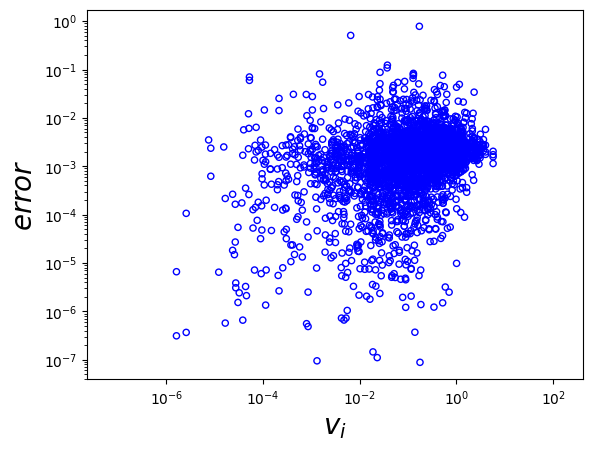

In [81]:
x = transitionRate['v'].to_numpy()
y = transitionRate['error'].to_numpy()

plt.scatter(x, y, s=20, marker='o', facecolors='none', edgecolors='b')
plt.xlabel(r'$v_{i}$', fontsize=20)
plt.ylabel(r'$error$', fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.axis('equal')
plt.show()